<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q7 PyTorch (40 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

While you were able to derive manual back-propagation rules for sigmoid and fully-connected layers, wouldn't it be nice if someone did that for lots of useful primatives and made it fast and easy to use for general computation?  Meet [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). Since we have high-dimensional inputs (images) and low-dimensional outputs (a scalar loss), it turns out **forward mode AD** is very efficient. Popular autodiff packages include [pytorch](https://pytorch.org/) (Facebook), [tensorflow](https://www.tensorflow.org/) (Google), [autograd](https://github.com/HIPS/autograd) (Boston-area academics). Autograd provides its own replacement for numpy operators and is a drop-in replacement for numpy, except you can ask for gradients now. The other two are able to act as shim layers for [cuDNN](https://developer.nvidia.com/cudnn), an implementation of auto-diff made by Nvidia for use on their GPUs. Since GPUs are able to perform large amounts of math much faster than CPUs, this makes the former two packages very popular for researchers who train large networks. Tensorflow asks you to build a computational graph using its API, and then is able to pass data through that graph. PyTorch builds a dynamic graph and allows you to mix autograd functions with normal python code much more smoothly, so it is currently more popular among CMU students. 

We will use [pytorch](https://pytorch.org/) as a framework. Many computer vision projects use neural networks as a basic building block, so familiarity with one of these frameworks is a good skill to develop. Here, we basically replicate and slightly expand our handwritten character recognition networks, but do it in PyTorch instead of doing it ourselves. Feel free to use any tutorial you like, but we like [the offical one](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or [this tutorial](http://cs231n.stanford.edu/notebooks/pytorch_tutorial.ipynb) (in a jupyter notebook) or [these slides](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture08.pdf (starting from number 35).

**For this section, you're free to implement these however you like. All of the tasks required here are fairly small and don't require a GPU if you use small networks. Including 7.2.**

### Q7.1 Train a neural network in PyTorch

#### Q7.1.1 (10 Points Code+WriteUp)
 
Re-write and re-train your fully-connected network on NIST36 in PyTorch. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

Train Epoch: 5
	Loss: 0.9894, Accuracy: 6910/10800 (64%)
	Test set: Average loss: 1.3607, Accuracy: 2297/3600 (64%)
Train Epoch: 10
	Loss: 0.9923, Accuracy: 7842/10800 (73%)
	Test set: Average loss: 1.0543, Accuracy: 2559/3600 (71%)
Train Epoch: 15
	Loss: 1.0172, Accuracy: 8258/10800 (76%)
	Test set: Average loss: 0.9794, Accuracy: 2611/3600 (73%)
Train Epoch: 20
	Loss: 0.7806, Accuracy: 8592/10800 (80%)
	Test set: Average loss: 0.9036, Accuracy: 2709/3600 (75%)
Train Epoch: 25
	Loss: 0.5374, Accuracy: 8839/10800 (82%)
	Test set: Average loss: 0.8408, Accuracy: 2747/3600 (76%)
Train Epoch: 30
	Loss: 0.5891, Accuracy: 9030/10800 (84%)
	Test set: Average loss: 0.8163, Accuracy: 2774/3600 (77%)
Train Epoch: 35
	Loss: 0.5636, Accuracy: 9208/10800 (85%)
	Test set: Average loss: 0.7943, Accuracy: 2762/3600 (77%)
Train Epoch: 40
	Loss: 0.2758, Accuracy: 9327/10800 (86%)
	Test set: Average loss: 0.7723, Accuracy: 2788/3600 (77%)
Train Epoch: 45
	Loss: 0.6017, Accuracy: 9502/10800 (88%)
	Test s

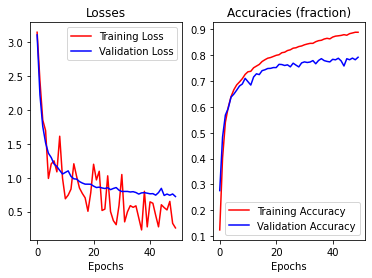

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
import torchvision.datasets
import torchvision.transforms

from ipynb.fs.defs.q2 import *


# YOUR CODE HERE
torch.manual_seed(12345)

train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_set = torch.utils.data.TensorDataset(
    torch.Tensor(train_data['train_data']),
    torch.Tensor(train_data['train_labels']).argmax(dim=1),
)
valid_set = torch.utils.data.TensorDataset(
    torch.Tensor(valid_data['valid_data']),
    torch.Tensor(valid_data['valid_labels']).argmax(dim=1),
)
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=25,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=100)


hidden_size = 64
epochs = 50


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.Wblayer1 = torch.nn.Linear(32 * 32, hidden_size)
        self.Wboutput = torch.nn.Linear(hidden_size, 36)

    def forward(self, x):
        x = self.Wblayer1(x)
        x = torch.sigmoid(x)
        x = self.Wboutput(x)
        return torch.nn.functional.log_softmax(x, dim=1)


def train(model, device, train_loader, optimizer, epoch, toprint):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim=1).eq(target).sum().item()
    if toprint:
        print('Train Epoch: {}\n\tLoss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            epoch,
            loss.item(),
            correct,
            len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)
        ))
    return loss.item(), correct / len(train_loader.dataset)


def test(model, device, test_loader, toprint):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output,
                                                           target,
                                                           reduction='sum').item()
            correct += output.argmax(dim=1).eq(target).sum().item()
    test_loss /= len(test_loader.dataset)
    if toprint:
        print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)
        ))
    return test_loss, correct / len(test_loader.dataset)


device = "cpu"
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(1, epochs + 1):
    ltrain, atrain =\
        train(model, device, train_loader, optimizer, epoch, toprint=epoch%5==0)
    ltest, atest =\
        test(model, device, valid_loader, toprint=epoch%5==0)
    train_losses.append(ltrain)
    train_accs.append(atrain)
    test_losses.append(ltest)
    test_accs.append(atest)

figure, axes = plt.subplots(1, 2)
axes[0].plot(train_losses, "r", label="Training Loss")
axes[0].plot(test_losses, "b", label="Validation Loss")
axes[1].plot(train_accs, "r", label="Training Accuracy")
axes[1].plot(test_accs, "b", label="Validation Accuracy")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")
axes[0].set_title("Losses")
axes[1].set_title("Accuracies (fraction)")
plt.show()

I've never worked with torch before, so I took inspiration from https://github.com/pytorch/examples/blob/master/mnist/main.py

#### Q7.1.2 (3 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on MNIST. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from time import time

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

mnist_train = MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=20, shuffle=True, num_workers=1)

mnist_test = MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=20, shuffle=True, num_workers=1)

print("dataset size train, test")
print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)


# YOUR CODE HERE
epochs = 5


class ConvNet(torch.nn.Module):
    def __init__(self, fcin=9216, fcmid=128, fcout=10):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(fcin, fcmid)
        self.fc2 = torch.nn.Linear(fcmid, fcout)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def conv_train(model, device, train_loader, optimizer, epoch, freq=500):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim=1).eq(target).sum().item()
        if batch_idx > 0 and batch_idx % freq == 0:
            print("batch {}/{} -- {}".format(batch_idx, len(train_loader), loss.item()))
    print('Train Epoch: {}\n\tLoss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch,
        loss.item(),
        correct,
        len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)
    ))
    return loss.item(), correct / len(train_loader.dataset)


def conv_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.cross_entropy(output,
                                                           target,
                                                           reduction='sum').item()
            correct += output.argmax(dim=1).eq(target).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss,
        correct,
        len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))
    return test_loss, correct / len(test_loader.dataset)

device = cuda


31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

96.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


MNISTconv_train_losses = []
MNISTconv_train_accs = []
MNISTconv_test_losses = []
MNISTconv_test_accs = []
for epoch in range(1, epochs + 1):
    ltrain, atrain = conv_train(model, device, train_loader, optimizer, epoch)
    ltest, atest = conv_test(model, device, test_loader)
    MNISTconv_train_losses.append(ltrain)
    MNISTconv_train_accs.append(atrain)
    MNISTconv_test_losses.append(ltest)
    MNISTconv_test_accs.append(atest)

batch 500/3000 -- 0.15755173563957214
batch 1000/3000 -- 0.15937450528144836
batch 1500/3000 -- 0.11881007999181747
batch 2000/3000 -- 0.216131329536438
batch 2500/3000 -- 0.021169286221265793
Train Epoch: 1
	Loss: 0.4372, Accuracy: 55323/60000 (92%)
	Test set: Average loss: 0.0519, Accuracy: 9839/10000 (98%)
batch 500/3000 -- 0.03833862766623497
batch 1000/3000 -- 0.12846779823303223
batch 1500/3000 -- 0.02506094239652157
batch 2000/3000 -- 0.025711840018630028
batch 2500/3000 -- 0.1077265590429306
Train Epoch: 2
	Loss: 0.0157, Accuracy: 58273/60000 (97%)
	Test set: Average loss: 0.0394, Accuracy: 9866/10000 (99%)
batch 500/3000 -- 0.09856685996055603
batch 1000/3000 -- 0.001134043326601386
batch 1500/3000 -- 0.01657307706773281
batch 2000/3000 -- 0.00757582625374198
batch 2500/3000 -- 0.0021689326968044043
Train Epoch: 3
	Loss: 0.0186, Accuracy: 58714/60000 (98%)
	Test set: Average loss: 0.0379, Accuracy: 9872/10000 (99%)
batch 500/3000 -- 0.04916290566325188
batch 1000/3000 -- 0.009

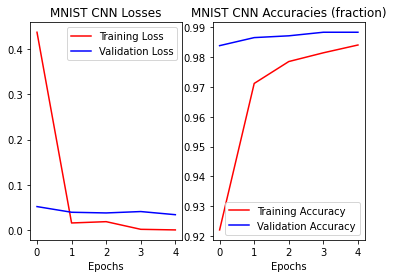

In [31]:
figure, axes = plt.subplots(1, 2)
axes[0].plot(MNISTconv_train_losses, "r", label="Training Loss")
axes[0].plot(MNISTconv_test_losses, "b", label="Validation Loss")
axes[1].plot(MNISTconv_train_accs, "r", label="Training Accuracy")
axes[1].plot(MNISTconv_test_accs, "b", label="Validation Accuracy")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")
axes[0].set_title("MNIST CNN Losses")
axes[1].set_title("MNIST CNN Accuracies (fraction)")
plt.show()

#### Q7.1.3 (2 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the included NIST36 dataset. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [4]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from time import time
import matplotlib.pyplot as plt

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))


class NIST36Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data.reshape([-1, 1, 32, 32]))
        self.labels = torch.FloatTensor(labels).argmax(dim=1)
        self.num_values = len(data)

    def __len__(self):
        return self.num_values

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    
print("Get dataset")
train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

train_set = NIST36Dataset(train_data['train_data'],
                          train_data['train_labels'])
valid_set = NIST36Dataset(valid_data['valid_data'],
                          valid_data['valid_labels'])
train_loader = DataLoader(train_set, batch_size=25, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=100)


print("dataset size train, test")
print(train_loader.dataset.data.shape)
print(valid_loader.dataset.data.shape)

device = cpu
Get dataset
dataset size train, test
torch.Size([10800, 1, 32, 32])
torch.Size([3600, 1, 32, 32])


In [19]:
model = ConvNet(fcin=12544, fcmid=256, fcout=36).to(device)
optimizer = torch.optim.Adadelta(model.parameters())
epochs = 5

nist36CNN_train_losses = []
nist36CNN_train_accs = []
nist36CNN_test_losses = []
nist36CNN_test_accs = []
for epoch in range(1, epochs + 1):
    ltrain, atrain = conv_train(model, device, train_loader, optimizer, epoch)
    ltest, atest = conv_test(model, device, valid_loader)
    nist36CNN_train_losses.append(ltrain)
    nist36CNN_train_accs.append(atrain)
    nist36CNN_test_losses.append(ltest)
    nist36CNN_test_accs.append(atest)

Train Epoch: 1
	Loss: 0.7763, Accuracy: 6019/10800 (56%)
	Test set: Average loss: 0.5733, Accuracy: 2995/3600 (83%)
Train Epoch: 2
	Loss: 0.6187, Accuracy: 8647/10800 (80%)
	Test set: Average loss: 0.4245, Accuracy: 3147/3600 (87%)
Train Epoch: 3
	Loss: 0.7746, Accuracy: 9216/10800 (85%)
	Test set: Average loss: 0.3762, Accuracy: 3195/3600 (89%)
Train Epoch: 4
	Loss: 0.3160, Accuracy: 9567/10800 (89%)
	Test set: Average loss: 0.3649, Accuracy: 3217/3600 (89%)
Train Epoch: 5
	Loss: 0.1751, Accuracy: 9726/10800 (90%)
	Test set: Average loss: 0.3479, Accuracy: 3228/3600 (90%)
Train Epoch: 6
	Loss: 0.1287, Accuracy: 9882/10800 (92%)
	Test set: Average loss: 0.3295, Accuracy: 3262/3600 (91%)
Train Epoch: 7
	Loss: 0.4451, Accuracy: 10011/10800 (93%)
	Test set: Average loss: 0.3324, Accuracy: 3254/3600 (90%)
Train Epoch: 8
	Loss: 0.2357, Accuracy: 10076/10800 (93%)
	Test set: Average loss: 0.3388, Accuracy: 3278/3600 (91%)
Train Epoch: 9
	Loss: 0.0441, Accuracy: 10142/10800 (94%)
	Test set: A

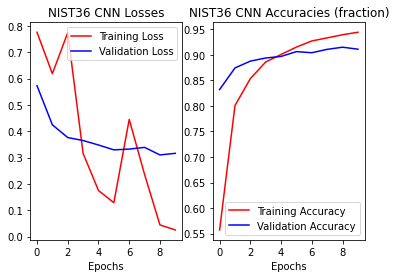

In [21]:
figure, axes = plt.subplots(1, 2)
axes[0].plot(nist36CNN_train_losses, "r", label="Training Loss")
axes[0].plot(nist36CNN_test_losses, "b", label="Validation Loss")
axes[1].plot(nist36CNN_train_accs, "r", label="Training Accuracy")
axes[1].plot(nist36CNN_test_accs, "b", label="Validation Accuracy")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")
axes[0].set_title("NIST36 CNN Losses")
axes[1].set_title("NIST36 CNN Accuracies (fraction)")
plt.show()

#### Q7.1.4 (15 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the EMNIST Balanced dataset  (available in *torchvision.datasets*, use *balanced* split) and evaluate it on the findLetters bounded boxes from the images folder. Find the accuracy on these bounded boxes.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [8]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from time import time

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")

EMNIST.url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
# Reference for transform function
# https://stackoverflow.com/a/54513835
transform=torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])
emnist_train = EMNIST(root="data", split='balanced', train=True, download=True, transform=transform)
trainset_loader = DataLoader(emnist_train, batch_size=20, shuffle=True, num_workers=1)

emnist_test = EMNIST(root="data", split='balanced', train=False, download=True, transform=transform)
testset_loader = DataLoader(emnist_test, batch_size=20, shuffle=True, num_workers=1)

# Ref: https://github.com/gaurav0651/emnist/blob/master/train_emnist.ipynb
label_map = [
    '0','1','2','3','4','5','6','7','8','9',
    'A','B','C','D','E','F','G','H','I','J',
    'K','L','M','N','O','P','Q','R','S','T',
    'U','V','W','X','Y','Z','a','b','d','e',
    'f','g','h','n','q','r','t'
]

print(trainset_loader.dataset.data.shape)
print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)
print("Number of labels: {}".format(len(label_map)))

# # Save a few images
# from matplotlib import pyplot
# for i in [4, 100, 1000, 2000, 3000, 3500, 4000, 5000]:
#     image = np.squeeze(np.array(trainset_loader.dataset[i][0]))
#     pyplot.imsave("eric_images/EMNIST_train_{}.png".format(i), image)

device = cuda
Get dataset
torch.Size([112800, 28, 28])
torch.Size([112800, 28, 28])
torch.Size([18800, 28, 28])


In [13]:
model = ConvNet(fcin=9216, fcmid=512, fcout=47).to(device)
optimizer = torch.optim.Adadelta(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
epochs = 6

EMNIST_train_losses = []
EMNIST_train_accs = []
EMNIST_test_losses = []
EMNIST_test_accs = []
for epoch in range(1, epochs + 1):
    ltrain, atrain = conv_train(
        model, device, trainset_loader, optimizer, epoch, freq=2000
    )
    ltest, atest = conv_test(model, device, testset_loader)
    EMNIST_train_losses.append(ltrain)
    EMNIST_train_accs.append(atrain)
    EMNIST_test_losses.append(ltest)
    EMNIST_test_accs.append(atest)

batch 2000/5640 -- 0.7189518809318542
batch 4000/5640 -- 0.6754404306411743
Train Epoch: 1
	Loss: 0.2625, Accuracy: 86621/112800 (77%)
	Test set: Average loss: 0.4574, Accuracy: 15988/18800 (85%)
batch 2000/5640 -- 0.2811504006385803
batch 4000/5640 -- 0.2108941376209259
Train Epoch: 2
	Loss: 0.1011, Accuracy: 94581/112800 (84%)
	Test set: Average loss: 0.4321, Accuracy: 16250/18800 (86%)
batch 2000/5640 -- 0.5559159517288208
batch 4000/5640 -- 0.6031148433685303
Train Epoch: 3
	Loss: 0.2959, Accuracy: 96049/112800 (85%)
	Test set: Average loss: 0.4116, Accuracy: 16192/18800 (86%)
batch 2000/5640 -- 0.3258620500564575
batch 4000/5640 -- 0.3741724193096161
Train Epoch: 4
	Loss: 0.2008, Accuracy: 96983/112800 (86%)
	Test set: Average loss: 0.3946, Accuracy: 16289/18800 (87%)
batch 2000/5640 -- 0.08348120748996735
batch 4000/5640 -- 0.42721471190452576
Train Epoch: 5
	Loss: 0.4835, Accuracy: 97413/112800 (86%)
	Test set: Average loss: 0.4006, Accuracy: 16374/18800 (87%)
batch 2000/5640 --

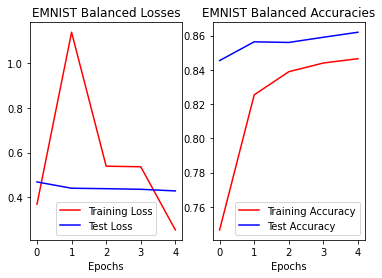

In [12]:
figure, axes = plt.subplots(1, 2)
axes[0].plot(EMNIST_train_losses, "r", label="Training Loss")
axes[0].plot(EMNIST_test_losses, "b", label="Test Loss")
axes[1].plot(EMNIST_train_accs, "r", label="Training Accuracy")
axes[1].plot(EMNIST_test_accs, "b", label="Test Accuracy")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")
axes[0].set_title("EMNIST Balanced Losses")
axes[1].set_title("EMNIST Balanced Accuracies")
plt.show()

In [32]:
from matplotlib import pyplot
import os
import skimage.io
import skimage.transform
import torch

from ipynb.fs.defs.q4 import findLetters, get_row_groups, pretty_letters


torch.manual_seed(123)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


def classify(model, device, image, letters):
    # Convert the image to the desired form (28x28, black background)
    image = skimage.transform.resize(image.T, (28, 28))
    inverted = np.abs(image - image.max())
    # pyplot.imsave("eric_images/EMNIST_real_example.png", inverted)

    # Convert to a tensor
    tensor = torch.from_numpy(inverted)
    # Add both batch and channel dimensions
    tensor = tensor.unsqueeze(dim=0).unsqueeze(dim=0)
    tensor = tensor.to(device, dtype=torch.float)
    # Call model
    probs = model(tensor)

    return letters[probs.argmax().item()]


characters = []
for img in sorted(os.listdir('images')):
    print(f"{img}")
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images', img)))
    bboxes, bw = findLetters(im1)
    _, row_groups = get_row_groups(bw.shape[0], bboxes)
    image_groups = pretty_letters(bw, row_groups)
    for image_row in image_groups:
        characters.append([classify(model, device, image, label_map) for image in image_row])
        print(" ".join(characters[-1]))

flattened = np.array(sum(characters, start=[]))
correct = np.array(
    list("TODOLIST1MAKEATODOLIST2CHECKOFFTHEFIRSTTHINGONTODOLIST" +
         "3REALIZEYOUHAVEALREADYCOMPLETED2THINGS4REWARDYOURSELFWITHANAP" +
         "ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890" +
         "HAIKUSAREEASYBUTSOMETIMESTHEYDONTMAKESENSEREFRIGERATOR" +
         "DEEPLEARNINGDEEPERLEARNINGDEEPESTLEARNING")
)
print(f"\nLength equal? {flattened.shape} == {correct.shape} ? {flattened.shape == correct.shape}")
minlen = min(len(flattened), len(correct))
print(f"Accuracy: {np.sum(flattened[:minlen] == correct[:minlen]) / len(correct)}")
nozeros = "".join(flattened).replace("0", "O")
nozeros = np.array(list(nozeros))
print(f"Accuracy **IF YOU SWAP 0 FOR O**: {np.sum(nozeros[:minlen] == correct[:minlen]) / len(correct)}")

01_list.jpg
T 0 D 0 L I S T
I M A K E A T 0 D 0 L I S T
2 C H E C K 0 F F T H E F I R S T
T H I N G 0 N T 0 D 0 L I S T
3 R K A L I 2 E Y 0 U H A V E A L R E A D Y
C 0 M P L E T E D 2 T H I N G S
4 R E W A R D Y 0 U R S E L F W I T H
A N A P
02_letters.jpg
A B C D E F G
H I J K L M N
0 P Q R S T U
V W X Y Z
1 2 3 q 5 6 7 8 9 0
03_haiku.jpg
H A I K U S A R E E A S Y
B U T S 0 M E T I M E S T H E Y D 0 N T M A K E S E N S E
R E F R I G E R A T 0 R
04_deep.jpg
D E E P L E A R N I N G
D E E P E R L E A R N I N G
D E E R E S T L E A R N I N G

Length equal? (246,) == (246,) ? True
Accuracy: 0.9186991869918699
Accuracy **IF YOU SWAP 0 FOR O**: 0.975609756097561


### Q7.2 Fine Tuning

#### Q7.2.1 (10 Points Code+WriteUp)
 
Fine-tune a single layer classifier using pytorch on the [flowers 17](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) (or [flowers 102](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)!) dataset using [squeezenet1\_1](https://pytorch.org/docs/stable/torchvision/models.html), as well as an architecture you've designed yourself (*3 conv layers, followed 2 fc layers, it's standard [slide 6](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture09.pdf)*) and trained from scratch. How do they compare? 
    
We include a script in `scripts/` to fetch the flowers dataset and extract it in a way that [PyTorch ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) can consume it, see [an example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision), from **data/oxford-flowers17**. You should look at how SqueezeNet is [defined](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py), and just replace the classifier layer. There exists a pretty good example for [fine-tuning](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) in PyTorch.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [5]:
# Code for fine-tune squeezenet1_1
# YOUR CODE HERE
import torch
import torch.nn
from torch.utils.data import DataLoader
import torchvision.models
from torchvision import transforms
from torchvision import datasets


def squeeze_train(model, device, train_loader, optimizer, epoch, freq=10):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        correct += output.argmax(dim=1).eq(target).sum().item()
        if batch_idx > 0 and batch_idx % freq == 0:
            print("batch {}/{} -- {}".format(batch_idx, len(train_loader), loss.item()))
    print('Train Epoch: {}\n\tLoss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        epoch,
        loss.item(),
        correct,
        len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)
    ))
    return loss.item(), correct / len(train_loader.dataset)


# Define your transforms for the training, validation, and testing sets
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
data_transforms = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)]),
    'val': transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)]),
    'test': transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)]),
}


# Load the datasets with ImageFolder
image_folders = {
    'train': datasets.ImageFolder('data/oxford-flowers17/train',
                                  transform=data_transforms['train']),
    'test': datasets.ImageFolder('data/oxford-flowers17/test',
                                 transform=data_transforms['test']),
    'val': datasets.ImageFolder('data/oxford-flowers17/val',
                                transform=data_transforms['val'])
}

image_datasets = {
    key: DataLoader(value, batch_size=20, shuffle=True)
    for key, value in image_folders.items()
}


model = torchvision.models.squeezenet1_1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(86528, 17),
)
for param in model.classifier.parameters():
    param.requires_grad = True
model.type(torch.FloatTensor)
epochs = 20
device = "cpu"

In [6]:
# Training the single linear layer
optimizer = torch.optim.Adadelta(model.parameters())

f17_train_losses = []
f17_train_accs = []
f17_test_losses = []
f17_test_accs = []
for epoch in range(1, epochs + 1):
    ltrain, atrain = squeeze_train(model, device, image_datasets["train"], optimizer, epoch)
    ltest, atest = conv_test(model, device, image_datasets["test"])
    f17_train_losses.append(ltrain)
    f17_train_accs.append(atrain)
    f17_test_losses.append(ltest)
    f17_test_accs.append(atest)

batch 10/34 -- 187.06124877929688
batch 20/34 -- 82.58929443359375
batch 30/34 -- 9.762029647827148
Train Epoch: 1
	Loss: 58.8620, Accuracy: 306/680 (45%)
	Test set: Average loss: 21.9777, Accuracy: 248/340 (73%)
batch 10/34 -- 25.236095428466797
batch 20/34 -- 20.385364532470703
batch 30/34 -- 26.91287612915039
Train Epoch: 2
	Loss: 17.5674, Accuracy: 494/680 (73%)
	Test set: Average loss: 31.3330, Accuracy: 244/340 (72%)
batch 10/34 -- 12.44061279296875
batch 20/34 -- 26.506092071533203
batch 30/34 -- 17.612024307250977
Train Epoch: 3
	Loss: 15.9514, Accuracy: 513/680 (75%)
	Test set: Average loss: 17.3417, Accuracy: 277/340 (81%)
batch 10/34 -- 23.050823211669922
batch 20/34 -- 11.006950378417969
batch 30/34 -- 14.987277030944824
Train Epoch: 4
	Loss: 11.0003, Accuracy: 557/680 (82%)
	Test set: Average loss: 14.2996, Accuracy: 286/340 (84%)
batch 10/34 -- 31.403057098388672
batch 20/34 -- 27.467992782592773
batch 30/34 -- 9.729055404663086
Train Epoch: 5
	Loss: 26.6208, Accuracy: 56

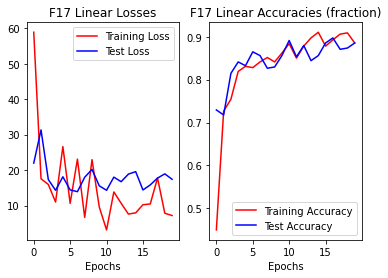

In [10]:
figure, axes = plt.subplots(1, 2)
axes[0].plot(f17_train_losses, "r", label="Training Loss")
axes[0].plot(f17_test_losses, "b", label="Test Loss")
axes[1].plot(f17_train_accs, "r", label="Training Accuracy")
axes[1].plot(f17_test_accs, "b", label="Test Accuracy")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")
axes[0].set_title("F17 Linear Losses")
axes[1].set_title("F17 Linear Accuracies (fraction)")
plt.show()

In [8]:
# Code for fine-tuning the network you designed
# YOUR CODE HERE
model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(512, 512, kernel_size=(3, 3)),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(512, 512, kernel_size=(3, 3)),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(512, 512, kernel_size=(3, 3)),
    torch.nn.ReLU(inplace=True),
    torch.nn.Flatten(),
    torch.nn.Linear(25088, 256),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(256, 17),
)
for param in model.classifier.parameters():
    param.requires_grad = True
model.type(torch.FloatTensor)


# Refresh
optimizer = torch.optim.Adadelta(model.parameters())


f17cnn_train_losses = []
f17cnn_train_accs = []
f17cnn_test_losses = []
f17cnn_test_accs = []
for epoch in range(1, epochs + 1):
    ltrain, atrain = squeeze_train(model, device, image_datasets["train"], optimizer, epoch)
    ltest, atest = conv_test(model, device, image_datasets["test"])
    f17cnn_train_losses.append(ltrain)
    f17cnn_train_accs.append(atrain)
    f17cnn_test_losses.append(ltest)
    f17cnn_test_accs.append(atest)

batch 10/34 -- 2.8275039196014404
batch 20/34 -- 2.8371288776397705
batch 30/34 -- 2.8299832344055176
Train Epoch: 1
	Loss: 2.8215, Accuracy: 41/680 (6%)
	Test set: Average loss: 2.8212, Accuracy: 32/340 (9%)
batch 10/34 -- 2.8035645484924316
batch 20/34 -- 2.76297926902771
batch 30/34 -- 2.806705951690674
Train Epoch: 2
	Loss: 2.7999, Accuracy: 55/680 (8%)
	Test set: Average loss: 2.7349, Accuracy: 44/340 (13%)
batch 10/34 -- 2.7234647274017334
batch 20/34 -- 2.5494441986083984
batch 30/34 -- 2.6844429969787598
Train Epoch: 3
	Loss: 2.6922, Accuracy: 78/680 (11%)
	Test set: Average loss: 2.4986, Accuracy: 56/340 (16%)
batch 10/34 -- 2.753629207611084
batch 20/34 -- 2.630272388458252
batch 30/34 -- 2.543935537338257
Train Epoch: 4
	Loss: 2.5095, Accuracy: 112/680 (16%)
	Test set: Average loss: 2.3899, Accuracy: 72/340 (21%)
batch 10/34 -- 2.447800397872925
batch 20/34 -- 2.3948142528533936
batch 30/34 -- 2.550459384918213
Train Epoch: 5
	Loss: 2.1607, Accuracy: 143/680 (21%)
	Test set:

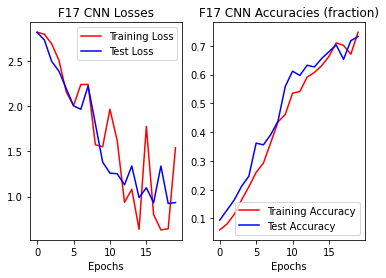

In [11]:
figure, axes = plt.subplots(1, 2)
axes[0].plot(f17cnn_train_losses, "r", label="Training Loss")
axes[0].plot(f17cnn_test_losses, "b", label="Test Loss")
axes[1].plot(f17cnn_train_accs, "r", label="Training Accuracy")
axes[1].plot(f17cnn_test_accs, "b", label="Test Accuracy")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("Epochs")
axes[1].set_xlabel("Epochs")
axes[0].set_title("F17 CNN Losses")
axes[1].set_title("F17 CNN Accuracies (fraction)")
plt.show()